# Assign simulated WEL pumping rates to RCH

In this notebook we demonstrate the use of the MODFLOW API to re-assign simulated well pumping rates as RCH, implemented at the system state solution level. The case demonstrated here is similar to what could be acomplished with the MDOFLOW 6 mover (MVR) package. However, the MVR package does not permit the RCH package as a receiver. 

We make use of a synthetic case. This case emulates a mine dewatering site in which dewater volumes are re-assigned as managed aquifer recharge. Well pumping rates are unknown beforehand. Here we emulate this with use of the AUTO_FLOW_REDUCE variable. If the AUTO_FLOW_REDUCE variable is set to a value which is greater than zero in the MODFLOW 6 well package input file, then the pumping rate assigned to a well is reduced if the head in the cell containing the well approaches the bottom of the aquifer.

The synthetic model starts with a steady-state stress period, followed by a 1000 day transient stress period. It has a single unconfined layer. There is a single WEL placed in the center of the model domain with a constant rate of 270 m3/d during the transient period (and the AUTO_FLOW_REDUCE option active). There are no other stresses or boundary-conditions. The transient stress period starts off with hydraulic head at 0m, which gradualy drops as the pump is active.

As the head at the well approaches the cell bottom, simulated pumping rates decrease. The MODFLOW API is used to access simulated pumping rates and re-assign these as recharge to two separate groups of nearby cells (emulating two managed aquifer recharge infiltration basins). Recharge is first assigned to one basin untill a "maximum infiltration volume" threshold is met. Then, the remainder of the simulating pumping rate is assigned to the second basin. 

In [1]:
import os 
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.insert(0,os.path.join("..", "..", "dependencies"))
import flopy
assert "dependencies" in flopy.__file__

# Build the model

In [2]:
sim_name = 'model'

## make model dir
sim_ws = os.path.join('.',sim_name)
if os.path.exists(sim_ws):
    shutil.rmtree(sim_ws)
else:
    os.makedirs(sim_ws)

# set executables path
if sys.platform == "win32":
    mf6_dll = "libmf6.dll"
    exe_name='mf6.exe'
else:
    mf6_dll = "libmf6.so"
    exe_name='mf6'
    
bin_dir = os.path.abspath('../../bin/')
mf6_exe = os.path.abspath(os.path.join(bin_dir, exe_name))
mf6_dll = os.path.abspath(os.path.join(bin_dir, mf6_dll))

# instantiate simulation
sim = flopy.mf6.MFSimulation(sim_name=sim_name, continue_=True,
                            exe_name=mf6_exe,
                            version="mf6", 
                            sim_ws=sim_ws, verbosity_level=0)

In [3]:
# define the time units for the simulation. All model inputs must have time-units of "day"
time_units = 'days'
#perioddata[perlen, nstp, tsmult]
perioddata = [(1.0, 1, 1.0), (1000.0, 100, 1.0)]
# the number of periods is 1
nper = len(perioddata)
# Create the TDIS Object
tdis = flopy.mf6.ModflowTdis(sim, pname="tdis",
                                  nper=nper, 
                                  perioddata=perioddata, 
                                  time_units=time_units)

In [4]:
# Instantiate the Flopy groundwater flow (gwf) model object, refercing the "sim" Simulation Object
model_name = 'gwf'
gwf = flopy.mf6.ModflowGwf(sim,
                            modelname=model_name, newtonoptions="newton",
                            save_flows=True, print_flows=True)
# Instantiate a Flopy `IMS` Package object
# Here you can set all the solver settings.
nouter = 500
ninner = 100
hclose = 1e-9
rclose = 1e-6

ims = flopy.mf6.ModflowIms(
            sim,
            print_option="summary",
            linear_acceleration="bicgstab",
            outer_maximum=nouter,
            outer_dvclose=hclose,
            inner_maximum=ninner,
            inner_dvclose=hclose,
            rcloserecord="{} strict".format(rclose),
        )
# lastly we need to register the MF6 model to an IMS package in the Simulation
sim.register_ims_package(ims, [gwf.name])

In [5]:
# set the length units. All model input values must have untis of length in "meters"
length_units = "METERS"
# number of layers
nlay = 1

# define the number of rows/columns
Lx = 1000
Ly = 1500
# we want our model grid to have cell sizes of 100 x 100 m
delr = 100 #row length
delc = 100 #column length
print(f'Cell size:{delr} x {delc}')
# we can compute the number of rows/columns:
ncol = int(Lx/delc)
nrow = int(Ly/delr)
print(f'Number of rows:{nrow}')
print(f'Number of columns:{ncol}')
# surface elevation of the systme is flat and equal to 50 m above some reference (e.g. sea-level)
top = 10
# the bottom of the upper-aquifer is at 40m; the aquitard at 35m and the lower aquifer at 0m
botm = -10

# create the DIS object
dis = flopy.mf6.ModflowGwfdis(
                            gwf,
                            nlay=nlay,
                            nrow=nrow,
                            ncol=ncol,
                            delr=delr,
                            delc=delc,
                            top=top,
                            botm=botm)

Cell size:100 x 100
Number of rows:15
Number of columns:10


In [6]:
# Now we can create the IC package
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=top)

In [7]:
# Next, let's create the NPF pacakge to assign values of hydraulic conductivity (K)
k = 1
# let us set the top layer as variably saturated (i.e. unconfiend) and the others as saturated
icelltype = 1
npf = flopy.mf6.ModflowGwfnpf(gwf, icelltype=icelltype, k=k, k33=k,
                              save_flows=True, 
                              save_specific_discharge=True) # so that we can plot specific discharge later

In [8]:
# CHD along both sides
chd_spd={}
spd = []
for row in range(nrow):
    spd.append(((0, row, 0), 0, 'chd'))
    spd.append(((0, row, ncol-1), 0, 'chd'))
chd_spd[0] = spd
chd_spd[1] = []
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chd_spd, boundnames=True)

chd_obs = {('chd.csv'): [ ('chd', 'CHD', 'chd')]}
chd.obs.initialize(digits=9, print_input=False,  
                   continuous=chd_obs)

In [9]:
# the name of the binary head file
headfile = f"{gwf.name}.hds"
head_filerecord = [headfile]
# the name of the binary budget file
budgetfile = f"{gwf.name}.cbb"
budget_filerecord = [budgetfile]

# which outputs are recored to the binary files
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
# which outputs are printed in the list file
printrecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
oc = flopy.mf6.ModflowGwfoc(gwf,
                            saverecord=saverecord,
                            head_filerecord=head_filerecord,
                            budget_filerecord=budget_filerecord,
                            printrecord=printrecord)

In [10]:
ss = nlay * [1e-5]
sy = nlay * [0.2]

sto = flopy.mf6.ModflowGwfsto(gwf,
                                steady_state={0:True, }, 
                                transient={1:True},
                                iconvert = [1],
                                ss=ss, 
                                sy=sy,
                                save_flows=True)

In [11]:
# dewatering WEL
wel_spd_data={}
wel_spd_data[1] = [((0,int(nrow/2),int(ncol/2)), -2*135, 'wel')]

wel = flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wel_spd_data, 
                                boundnames=True, pname='wel-1',
                                auto_flow_reduce=1e-1,  afrcsv_filerecord ='hd1h_well_reduce.csv')

# build obs data 
wel_obs = {('wel.csv'):[('wel','WEL','wel')]}

# initialize obs package
wel.obs.initialize(digits=9, print_input=True, 
                   continuous=wel_obs)

### Empty package for API

We will be assigning the managed aquifer recharge using an "empty" API package by instantiating a `flopy.mf6.ModflowGwfapi()`. (This is similar to the approach implemented in the modflow api paper "Custom EVT Package" example.) During the MODFLOW API assisted run, we will access this package, define active nodes and assign recharge values. 


In [12]:
api_package = flopy.mf6.ModflowGwfapi(gwf, 
                        pname="MAR", 
                        maxbound=ncol*nrow) 

In [13]:
# Write the model files
sim.write_simulation()

# Run with MODFLOW6

First we will run the model without using the API. In this case only the wel is active, there is no managed aquifer recharge being re-assigned.

In [14]:
success, buff = sim.run_simulation()
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

# Postprocess
Make a plot of heads at the end of the model run.

In [15]:
def plot_heads():
    hds = gwf.output.head()
    heads = hds.get_alldata()

    head = heads[-1]

    fig = plt.figure(figsize=(5, 5), constrained_layout=True)
    # first instantiate a PlotMapView
    mm = flopy.plot.PlotMapView(model=gwf, layer=0)

    # Plot heads
    # plot the array of heads 
    head_array = mm.plot_array(head, cmap='Blues')
    # add contour lines with contour_array()
    contours = mm.contour_array(head, colors='black')
    # add labels to contour lines
    plt.clabel(contours, fmt="%2.1f")
    # add a color bar
    cb = plt.colorbar(head_array, shrink=0.5, )
    cb.ax.set_title('Heads')
    # Plot grid 
    # you can plot BC cells using the plot_bc() 
    #mm.plot_bc('CHD', color='blue', alpha=0.2)
    # and plot the model grid if desired
    mm.plot_grid(lw=0.5)
    return

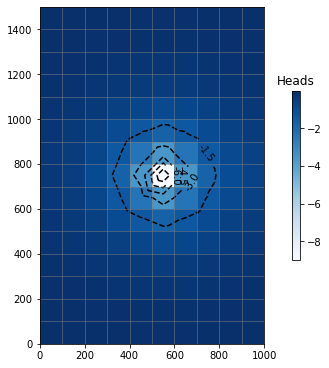

In [16]:
# make plot of heads
plot_heads()

In [17]:
# get budget observations from lst file
def extract_hds_arrays_and_list_dfs(workspace='.'):
    import os
    import flopy
    lst = flopy.utils.Mf6ListBudget(os.path.join(workspace, "gwf.lst"))
    inc,cum = lst.get_dataframes(diff=True,start_datetime=None)
    inc.columns = inc.columns.map(lambda x: x.lower().replace("_","-"))
    cum.columns = cum.columns.map(lambda x: x.lower().replace("_", "-"))
    inc.index.name = "totim"
    cum.index.name = "totim"
    inc.to_csv(os.path.join(workspace, "inc.csv"))
    cum.to_csv(os.path.join(workspace, "cum.csv"))
    print('budget values written to: inc.csv,cum.csv')
    return inc, cum

### Check the WEL rates

As you can see in the plot below, despite a constant asigned pumping rate of 270 $m{^3}/d$, WEL rates decline over time as the aquifer is depleted.

budget values written to: inc.csv,cum.csv


<AxesSubplot:xlabel='totim'>

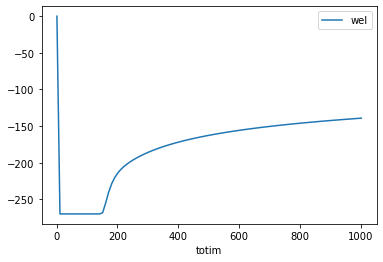

In [18]:
inc0, cum0 = extract_hds_arrays_and_list_dfs(sim_ws)
inc0.plot(y=['wel'])

# MODFLOW API

Now we will run the model using the MODFLOW API. 

In [19]:
from modflowapi import ModflowApi

The following couple of functions are used during the model run.

In [20]:
def get_rhs_per_node(tot_vol_in, nodes):
    node_height = tot_vol_in / cell_areas[nodes].sum()
    node_vols = node_height * cell_areas[nodes]
    return node_vols

In [21]:
def set_mar_rhs(nodes, tot_vol_in):
    node_vols = get_rhs_per_node(tot_vol_in, nodes)
    # now we can update the MAR package RHS variable
    # we need to assign new values only to the correct indices which correpsond to MAR nodes
    # this requires finding the array indeiices which corresnpodn to the MAR
    node_indices = np.where(np.in1d(mar_nodes, nodes))[0]
    rhs[node_indices] = -1 * node_vols #-1 because recharge is subtracted from RHS
    return

### Start the API managed model run:

In [22]:
# We will access package variables using the model and package Names
name = gwf.name.upper()
mar_package_name =  api_package.name[0].upper() 

# make a container to keep track of calcualted MAR rates
mar = []

# start the API
print('Starting MF6 API managed run.')
mf6 = ModflowApi(mf6_dll, working_directory=sim_ws)
# initialize the model
mf6.initialize()

# get the API package NBOUND so that we can update it.
nbound_address = mf6.get_var_address("NBOUND", name.upper(), mar_package_name)
nodelist_address = mf6.get_var_address("NODELIST", name.upper(), mar_package_name)

# access the values
# .get_value() returns a copy; .get_value_ptr() returns a pointer to the values

# get pointer to simulated heads; we will use this at the iteration level 
# to calculate if MAR must be redistributed
head_tag = mf6.get_var_address("X", name.upper())
head = mf6.get_value_ptr(head_tag)

# get cell tops
top_address = mf6.get_var_address("TOP", name.upper(), "DIS")
cell_top = mf6.get_value(top_address)

# get cell areas
area_address = mf6.get_var_address("AREA", name.upper(), "DIS")
cell_areas = mf6.get_value(area_address)

# get the MAR node numbers from lay,row,col
mar_node_n = gwf.modelgrid.get_node([(0,5,5), (0,5,6), (0,5,7)])
mar_node_s = gwf.modelgrid.get_node([(0,9,5), (0,9,6), (0,9,7)])
# set the MAR package NODELIST
mar_nodes = mar_node_n.copy()
mar_nodes.extend(mar_node_s)
mar_nodes=np.array(mar_nodes, dtype=np.int32)
# update the NBOUND, we specify the number of nodes that are active in the package
nbound = mf6.get_value_ptr(nbound_address)
nbound[0] = mar_nodes.shape[0]
# update the nodelist values, specifies which nodes are active
mf6.set_value(nodelist_address, mar_nodes)

# we will assign recharge by accesign the RHS (righ-hand-side) variable
# for recharge, recharge rate per cell is added to RHS; see the MF6 manual re-RCH package
rhs_address = mf6.get_var_address("RHS", name.upper(), mar_package_name)
# access rhs to provide a data structure for assigning later on
rhs = mf6.get_value(rhs_address)

# time loop
current_time = mf6.get_current_time()
end_time = mf6.get_end_time()

# model time loop
while current_time < end_time:
    # get dt and prepare for non-linear iterations
    dt = mf6.get_time_step()
    mf6.prepare_time_step(dt)

    # convergence loop
    kiter = 0
    mf6.prepare_solve(1)

    # get the max number of iterations
    address = ["MXITER", "SLN_1"]
    mxittag = mf6.get_var_address(*address)
    mxit = mf6.get_value_ptr(mxittag)
    # try untill convergence or max number of iterations are reached
    while kiter < mxit:
        # get dewater volumes
        wel_vol = abs(mf6.get_value(f'{name}/WEL-1/RHS')).sum()
        
        # specify the max mar rate for the north mar zone
        max_mar_vol= 140
        # if wel rates are grater than the max rate, assign the difference to the other zone
        if wel_vol > max_mar_vol:
            mar_vol_n = max_mar_vol
            mar_vol_s = wel_vol - mar_vol_n
        else:
            mar_vol_n = wel_vol
            mar_vol_s = 0
        # update the rhs array
        set_mar_rhs(mar_node_n, mar_vol_n)
        set_mar_rhs(mar_node_s,  mar_vol_s)
        # assign the updated array to the API package
        mf6.set_value(rhs_address, rhs)  
        
        # solve the iteration
        has_converged = mf6.solve(1)
        # if conferegence is achieved, stop, otherwise repeat
        kiter += 1
        if has_converged:
            break

    # Finalize the time step
    mf6.finalize_solve(1)
    mar.append((current_time, mar_vol_n, mar_vol_s))
    print('Model simulation time:', current_time, 'mar_n:',mar_vol_n, 'mar_s:',mar_vol_s )
    # finalize time step and update time
    mf6.finalize_time_step()
    current_time = mf6.get_current_time()
# finish the run
mf6.finalize()
print('MF6 terminated sucesfully.')

Starting MF6 API managed run.
Model simulation time: 0.0 mar_n: 0.0 mar_s: 0
Model simulation time: 1.0 mar_n: 140 mar_s: 130.0
Model simulation time: 11.0 mar_n: 140 mar_s: 130.0
Model simulation time: 21.0 mar_n: 140 mar_s: 130.0
Model simulation time: 31.0 mar_n: 140 mar_s: 130.0
Model simulation time: 41.0 mar_n: 140 mar_s: 130.0
Model simulation time: 51.0 mar_n: 140 mar_s: 130.0
Model simulation time: 61.0 mar_n: 140 mar_s: 130.0
Model simulation time: 71.0 mar_n: 140 mar_s: 130.0
Model simulation time: 81.0 mar_n: 140 mar_s: 130.0
Model simulation time: 91.0 mar_n: 140 mar_s: 130.0
Model simulation time: 101.0 mar_n: 140 mar_s: 130.0
Model simulation time: 111.0 mar_n: 140 mar_s: 130.0
Model simulation time: 121.0 mar_n: 140 mar_s: 130.0
Model simulation time: 131.0 mar_n: 140 mar_s: 130.0
Model simulation time: 141.0 mar_n: 140 mar_s: 130.0
Model simulation time: 151.0 mar_n: 140 mar_s: 130.0
Model simulation time: 161.0 mar_n: 140 mar_s: 127.54730955892444
Model simulation tim

# Postprocess:

In [23]:
# get the budget values
inc1, cum1 = extract_hds_arrays_and_list_dfs(sim_ws)

budget values written to: inc.csv,cum.csv


Check if the budget of the API and WEL pacakges match. Rates into the API packge should be equal to rates out of the WEL package:

<AxesSubplot:xlabel='totim'>

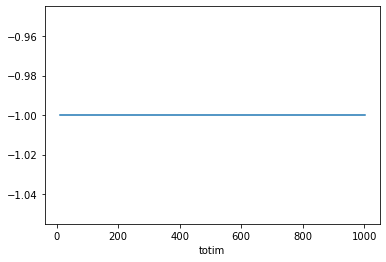

In [24]:
(inc1.api / inc1.wel).plot()

Plot API (or managed aquifer recharge) and WEL rates over time:

<AxesSubplot:xlabel='totim'>

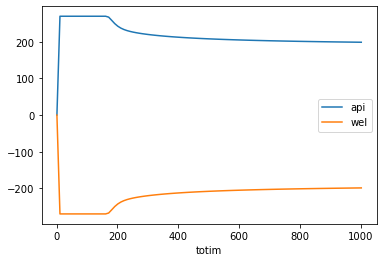

In [25]:
inc1.plot(y=['api', 'wel'])

Compare simulated WEL pumping rates with and without managed aquifer recharge:

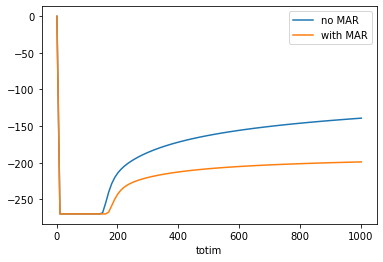

In [26]:
inc0.wel.plot(label='no MAR')
inc1.wel.plot(label='with MAR')
plt.legend()

Make a plot of heads at the end of the model run time. Note the mound at the northern managed aquifer recharge zone. Recharge in the southern zone is less noticebale at ths scale. This is because, as WEL rates decrease, managed aquifer recharge to the southern zone is decreased first.

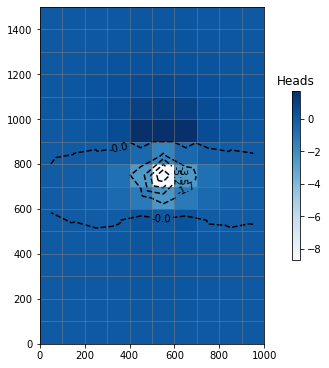

In [27]:
plot_heads()

Plot the time series of managed aquifer recharge rates to each zone:

<AxesSubplot:xlabel='time'>

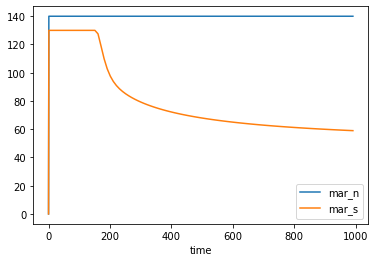

In [28]:
mar = pd.DataFrame(mar, columns=['time', 'mar_n', 'mar_s']).set_index('time')
mar.plot()